In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import xgboost as xgb
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("/kaggle/input/hourly-energy-consumption/PJME_hourly.csv")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


The data goes from 2002 to 2018

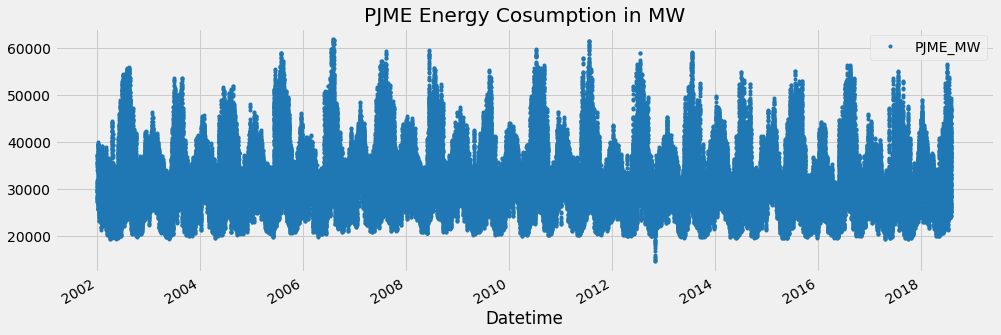

In [5]:
df.plot(style = ".", figsize = (15, 5), color = color_pal[0], title = "PJME Energy Cosumption in MW")
plt.show()

Train/Test Split

In [6]:
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index >= "01-01-2015"]

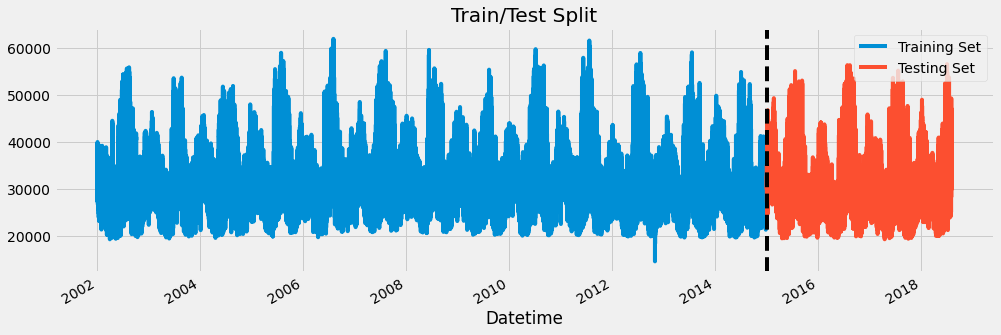

In [7]:
fig, ax = plt.subplots(figsize = (15, 5))
train.plot(ax = ax, label = "Training Set", title = "Train/Test Split")
test.plot(ax = ax, label = "Testing Set")
ax.axvline("01-01-2015", color = "black", ls = "--")
ax.legend(["Training Set", "Testing Set"])
plt.show()

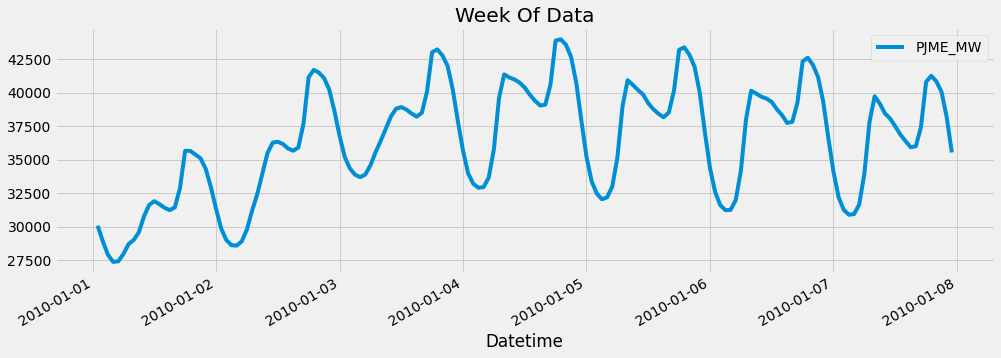

In [8]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

Feature Creation

In [9]:
def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    return df

In [10]:
df = create_features(df)

Visualize Feature/Target Relationship

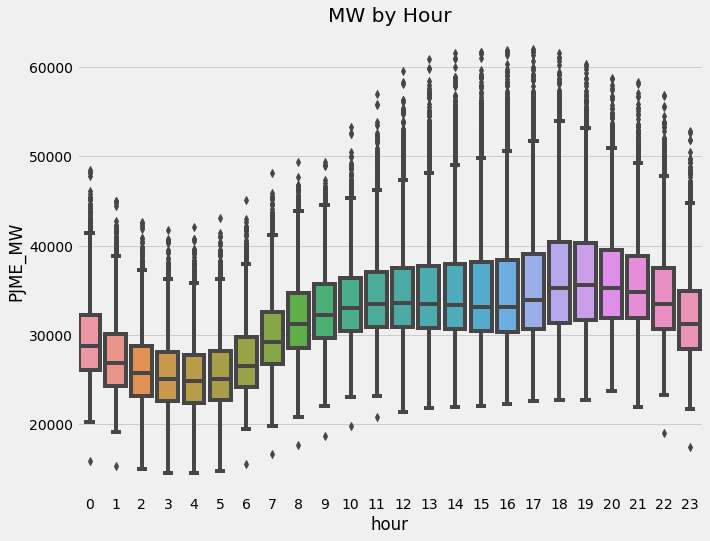

In [11]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df, x = "hour", y = "PJME_MW")
ax.set_title("MW by Hour")
plt.show()

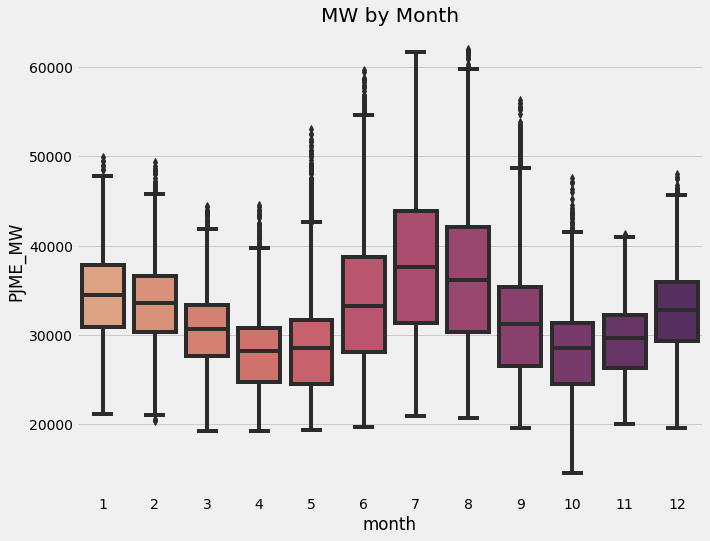

In [12]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df, x = "month", y = "PJME_MW", palette = "flare")
ax.set_title("MW by Month")
plt.show()

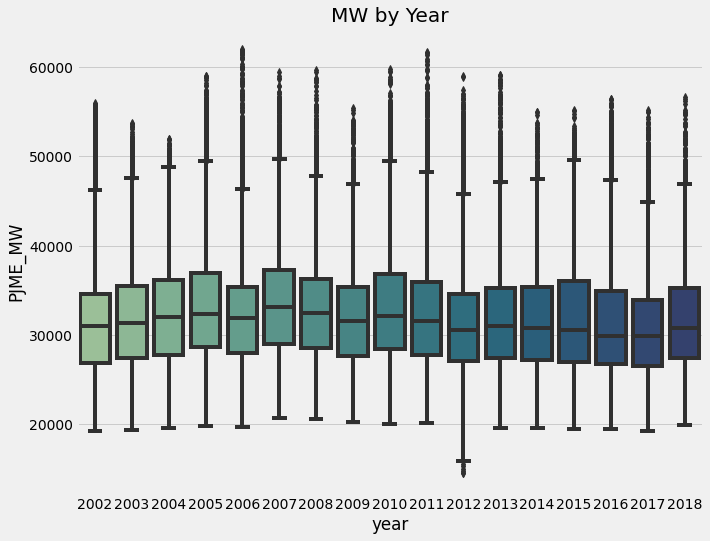

In [13]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df, x = "year", y = "PJME_MW", palette = "crest")
ax.set_title("MW by Year")
plt.show()

Creating the Model

In [14]:
train = create_features(train)
test = create_features(test)

In [15]:
FEATURES = ['hour', 'dayofweek', 'month', 'quarter', 'year',
       'dayofyear']
TARGET = ['PJME_MW']

In [16]:
X_train = train[FEATURES]
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_test = test[TARGET]

In [17]:
reg = xgb.XGBRegressor(n_estimators = 1000, earlu_stopping_rounds = 50, learning_rate = 0.01)
reg.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_test, Y_test)],verbose = 50)

[11:17:32] WARNING: ../src/learner.cc:627: 
Parameters: { "earlu_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[50]	validation_0-rmse:19921.65047	validation_1-rmse:18992.95177
[100]	validation_0-rmse:12342.13873	validation_1-rmse:11517.66004
[150]	validation_0-rmse:7889.19101	validation_1-rmse:7328.26832
[200]	validation_0-rmse:5373.33346	validation_1-rmse:5165.30811
[250]	validation_0-rmse:4032.73892	validation_1-rmse:4188.83787
[300]	validation_0-rmse:3375.20923	validation_1-rmse:3829.25476
[350]	validation_0-rmse:3062.84448	validation_1-rmse:3726.58066
[400]	validation_0-rmse:2882.55200	validation_1-rmse:3715.04915
[450]	validation_0-rmse:2769.28894	validation_1-r

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             earlu_stopping_rounds=50, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, ...)

Feature Importance

In [18]:
reg.feature_importances_

array([0.47357646, 0.12605509, 0.22777939, 0.        , 0.0319269 ,
       0.14066222], dtype=float32)

In [19]:
fi = pd.DataFrame(data = reg.feature_importances_, index = reg.feature_names_in_, columns = ["Importance"])

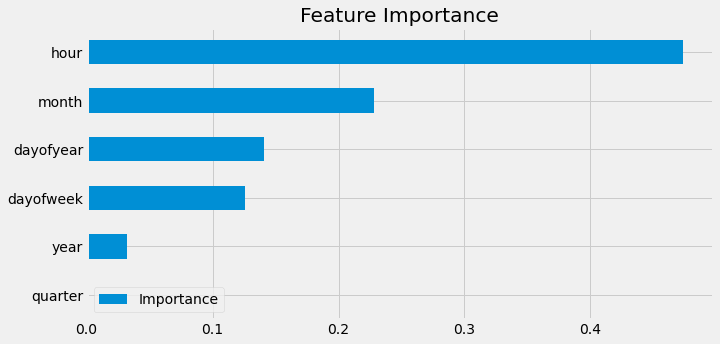

In [20]:
fi.sort_values("Importance").plot(kind = "barh", title = "Feature Importance", figsize = (10, 5))
plt.show()

Forecast on Test

In [21]:
test["predictions"] = reg.predict(X_test)

In [22]:
df = df.merge(test[["predictions"]], how= "left",left_index = True, right_index = True)

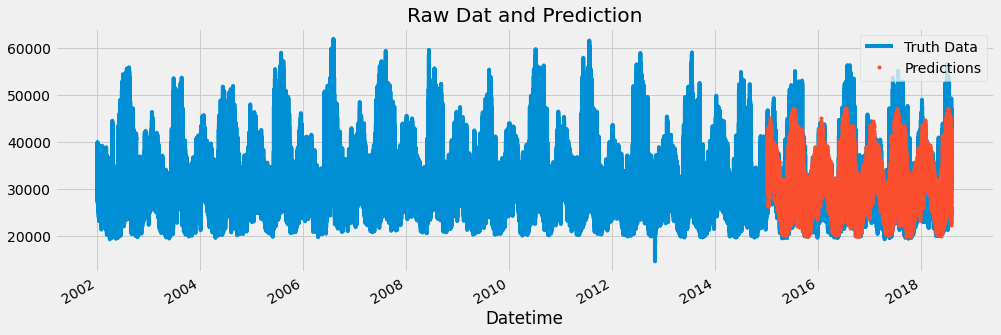

In [23]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['predictions'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

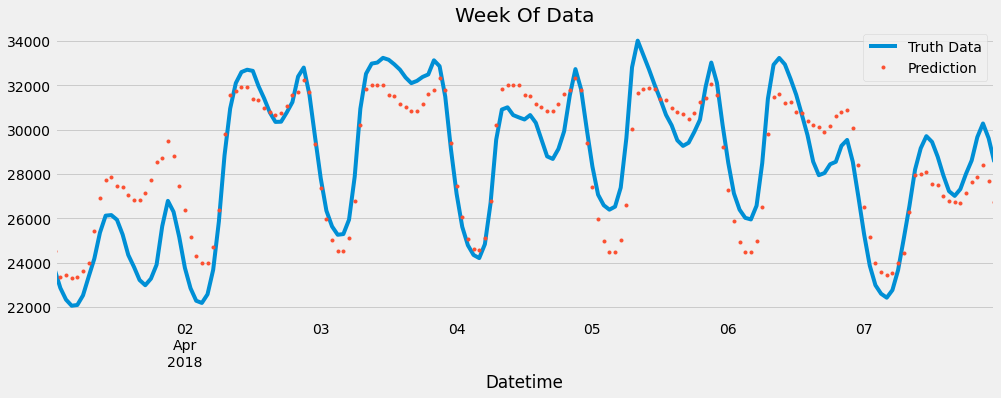

In [24]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['predictions'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(test["PJME_MW"], test["predictions"]))
print(f"RMSE score on the test set :{score:0.2f}")

RMSE score on the test set :3940.75
